In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [15]:
def functions(x,y):
    return [2*x + 3*y, x**2+y**3, 2*np.cos(x)+np.exp(y)]

In [16]:
points = np.array([[1, 1],[1, 2],[1, 3],[2, 1],[2, 2],[2, 3],[3, 1],[3, 2],[3, 3]])
func_res = np.apply_along_axis(lambda row: functions(row[0], row[1]), axis=1, arr=points)
func_res[:,0]


array([ 5.,  8., 11.,  7., 10., 13.,  9., 12., 15.])

In [17]:
points

array([[1, 1],
       [1, 2],
       [1, 3],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 1],
       [3, 2],
       [3, 3]])

In [18]:
def bilinear_interpolation(x, y, known_points, known_values): 
    """
    Функція для білінійної інтерполяції значення у точці (x, y) за заданими відомими точками та їхніми значеннями.

    Args:
        x, y (float): Координати точки для інтерполяції.
        known_points (numpy.ndarray): Масив відомих точок у форматі [[x1, y1], [x2, y2], ...].
        known_values (numpy.ndarray): Масив відомих значень, пов'язаних із відомими точками.

    Returns:
        float: Інтерпольоване значення у точці (x, y).
    """
    if len(known_values) < 4 or len(known_points) < 4:
        print("Не вистачає відомих точок для білінійної інтерполяції.")
        return None
    
    # Знаходимо індекси точок Q11, Q12, Q21 та Q22
    idx11 = np.where((known_points[:, 0] < x) & (known_points[:, 1] < y))[0]
    idx12 = np.where((known_points[:, 0] < x) & (known_points[:, 1] > y))[0]
    idx21 = np.where((known_points[:, 0] > x) & (known_points[:, 1] < y))[0]
    idx22 = np.where((known_points[:, 0] > x) & (known_points[:, 1] > y))[0]

    # Перевіряємо, що є хоча б одна точка у кожному квадранті
    if len(idx11) == 0 or len(idx12) == 0 or len(idx21) == 0 or len(idx22) == 0:
        print("Не вдалося знайти відомі точки в кожному квадранті.")
        return None

    # Вибираємо значення відомих точок
    f_Q11 = known_values[idx11[0]]
    f_Q12 = known_values[idx12[0]]
    f_Q21 = known_values[idx21[0]]
    f_Q22 = known_values[idx22[0]]

    # Знаходимо координати відомих точок
    x1, y1 = known_points[idx11[0]]
    x2, y2 = known_points[idx22[0]]

    # Робимо білінійну інтерполяцію
    z = (f_Q11 * (x2 - x) * (y2 - y) / ((x2 - x1) * (y2 - y1))) + \
        (f_Q21 * (x - x1) * (y2 - y) / ((x2 - x1) * (y2 - y1))) + \
        (f_Q12 * (x2 - x) * (y - y1) / ((x2 - x1) * (y2 - y1))) + \
        (f_Q22 * (x - x1) * (y - y1) / ((x2 - x1) * (y2 - y1)))
    
    return z


In [19]:

# Тепер спробуємо декілька значень x та y та перевіримо, чи працює формула
print("f(1.5, 1.5) =", bilinear_interpolation(1.5, 1.5, points, func_res[:,0]))
print("f(1.25, 1.75) =", bilinear_interpolation(1.25, 1.75,points, func_res[:,0]))
print("f(1.5, 1.5) =", bilinear_interpolation(1.5, 1.5, points, func_res[:,1]))
print("f(1.25, 1.75) =", bilinear_interpolation(1.25, 1.75,points, func_res[:,1]))
print("f(1.5, 1.5) =", bilinear_interpolation(1.5, 1.5, points, func_res[:,2]))
print("f(1.25, 1.75) =", bilinear_interpolation(1.25, 1.75,points, func_res[:,2]))
print(functions(1.5, 1.5))


f(1.5, 1.5) = 7.5
f(1.25, 1.75) = 7.75
f(1.5, 1.5) = 7.0
f(1.25, 1.75) = 8.0
f(1.5, 1.5) = 5.177824433015845
f(1.25, 1.75) = 6.823742571841388
[7.5, 5.625, 4.62316347367347]


In [20]:
from scipy.interpolate import griddata

# Відомі точки та їх значення
known_points = np.array([[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]])
known_values = func_res[:,2]

# Точка, для якої потрібно провести інтерполяцію
x_interp, y_interp = 1.5, 1.5

# Використовуємо griddata для інтерполяції
interp_value = griddata(known_points, known_values, (x_interp, y_interp), method='linear')

print("Інтерпольоване значення:", interp_value)


Інтерпольоване значення: 5.177824433015845


In [21]:
def read_image(path):
    '''Read image and return the image propertis.
    Parameters:
    path (string): Image path

    Returns:
    numpy.ndarray: Image exists in "path"
    list: Image size
    tuple: Image dimension (number of rows and columns)
    '''
    img = cv2.imread(path) 
    size = img.shape
    dimension = (size[0], size[1])

    return img, size, dimension



In [22]:

def image_change_scale(img, dimension, scale=100, interpolation=cv2.INTER_LINEAR):
    scale /= 100
    new_dimension = (int(dimension[1]*scale), int(dimension[0]*scale))
    resized_img = cv2.resize(img, new_dimension, interpolation=interpolation)

    return resized_img


In [23]:
image_test, size_test, dimension_test = read_image("doggy.jpg")

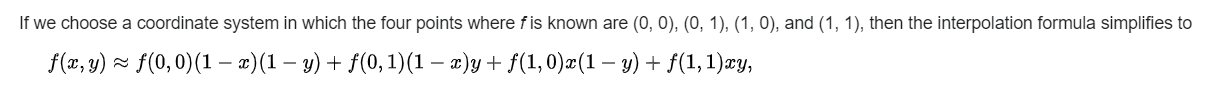

In [87]:
def bilinear_interpolation(image, scale_factor):
    # Определение новых размеров изображения
    new_height = int(image.shape[0] * scale_factor)
    new_width = int(image.shape[1] * scale_factor)
    
    # Создание нового изображения с новыми размерами
    new_image = np.zeros((new_height, new_width), dtype=np.uint8)

    # Выполнение билинейной интерполяции для каждого канала RGB
    for channel in range(1):
        for i in range(new_height):
            for j in range(new_width):
                # Нахождение координат пикселей в исходном изображении
                y_original = i / scale_factor
                x_original = j / scale_factor
                
                # Нахождение координат угловых пикселей
                y1 = int(y_original)
                y2 = min(y1 + 1, image.shape[0] - 1)
                x1 = int(x_original)
                x2 = min(x1 + 1, image.shape[1] - 1)
                
                # Коэффициенты для интерполяции
                dy = y_original - y1
                dx = x_original - x1
                
                # Интерполяция значений
                interpolated_value = (1 - dx) * (1 - dy) * image[y1, x1] + \
                                     dx * (1 - dy) * image[y1, x2] + \
                                     (1 - dx) * dy * image[y2, x1] + \
                                     dx * dy * image[y2, x2]
                
                new_image[i, j] = interpolated_value
    
    return new_image

In [94]:
im_test = np.array([[54,12,110],[11,32,84],[8,25,96]])

In [97]:
new_image = bilinear_interpolation(im_test, [5,5])

IndexError: tuple index out of range

In [90]:
new_image

array([[ 54,  33,  12,  61, 110, 110],
       [ 32,  27,  22,  59,  97,  97],
       [ 11,  21,  32,  58,  84,  84],
       [  9,  19,  28,  59,  90,  90],
       [  8,  16,  25,  60,  96,  96],
       [  8,  16,  25,  60,  96,  96]], dtype=uint8)

In [93]:
def bilinear_interpolation(image, dimension):
    '''Bilinear interpolation method to convert small image to original image
    Parameters:
    img (numpy.ndarray): Small image
    dimension (tuple): resizing image dimension

    Returns:
    numpy.ndarray: Resized image
    '''
    height = image.shape[0]
    width = image.shape[1]

    scale_x = (width)/(dimension[1])
    scale_y = (height)/(dimension[0])

    new_image = np.zeros((dimension[0], dimension[1], image.shape[2]))

    for k in range(1):
        for i in range(dimension[0]):
            for j in range(dimension[1]):
                x = (j+0.5) * (scale_x) - 0.5
                y = (i+0.5) * (scale_y) - 0.5

                x_int = int(x)
                y_int = int(y)

                # Prevent crossing
                x_int = min(x_int, width-2)
                y_int = min(y_int, height-2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = image[y_int, x_int]
                b = image[y_int, x_int+1]
                c = image[y_int+1, x_int]
                d = image[y_int+1, x_int+1]

                pixel = a*(1-x_diff)*(1-y_diff) + b*(x_diff) * \
                    (1-y_diff) + c*(1-x_diff) * (y_diff) + d*x_diff*y_diff

                new_image[i, j] = pixel.astype(np.uint8)

    return new_image
